# CNN for DOA estimation

### Imports

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import pandas as pd
import pyroomacoustics as pra
from pyroomacoustics.beamforming import MicrophoneArray
import math
import sys
from collections import defaultdict
import os
from itertools import combinations
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
%matplotlib inline

### Creating a room for simulation

In [2]:
def create_simulation_room(room_dim=[4, 4, 2], mic_pos=[2, 2, 1], room_fs=16000):
    """
    Utility function to create a shoebox room,
    with a microphone array included.
    """
    
    # Initialize room
    room = pra.ShoeBox(room_dim, fs=room_fs)

    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.045

    # Generate the microphone array
    mic_array_2D = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=mic_radius)
    mic_array_3D = np.vstack((mic_array_2D, [mic_height] * 6))
    
    # Add the microphone array to room
    room.add_microphone_array(mic_array_3D)
    
    return room


def create_sound_sources(resolution=1):
    """
    Function that creates a list of all audio source,
    that will be placed inside the room for simulation.
    """
    
    #Specify angle in distance ranges
    angle_range = range(0, 360, resolution)
    dist_range = np.linspace(0.5, 2, 10)
   
    sources = defaultdict(list)

    for angle in angle_range:
        for R in dist_range:
            source = [R * math.cos(math.radians(angle)) + 2, R * math.sin(math.radians(angle)) + 2, 1]
            sources[angle].append((R, source))
            
    return sources


def simulate_room(audio_file, resolution=1, room_dim=[4, 4, 2], mic_pos=[2, 2, 1], label_res=20):
    """
    Function to simulate room with specified dimensions and microphone array position.
    Generates CSV files for all angle/distance combinations.
    
    Returns: a dictionary with all dataframes that were created.
    Keys are in a form of (angle, distance) tuples
    """
    
    file_name = os.path.basename(audio_file).split('.')[0]
    
    # Read the audio file
    fs, audio = wavfile.read(audio_file)
    
    # Create all sound sources
    sources = create_sound_sources(resolution)
    
    # Generate columns' names for each CSV file
    df_cols = [f'mic_{i}' for i in range(1, 7)]
    
    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        if angle % label_res == 0:
            print(f'Simulating {angle}-{angle + label_res - 1} degrees:', end=' ')
            
        sys.stdout.write("#")
        
        dataframes = []
        
        for dist, source in sources:
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs)
            room.add_source(source, signal=audio, delay=0.0)
            room.simulate()

            # Exctract simulated signal for each microphone
            data = room.mic_array.signals.T
            
            # Save array data to a CSV file
            df = pd.DataFrame(data=data, columns=df_cols, dtype=np.int16)
            df['angle'] = angle    
            dataframes.append(df)
          
        angle_df = pd.concat(dataframes, ignore_index=True)
        angle_df.to_csv(f'../training_data/angle_{angle}_{file_name}.csv', index=False)
        
        if angle % label_res == label_res - 1:
            print(' Done.')
            
    print('Simulation successful!')


# Simulate room for every audio file in the directory
sounds = os.listdir('../sounds')

for sound in sounds:
    # Call the function above and store all results
    print('Audio file: ' + sound)
    dataframes = simulate_room(f'../sounds/{sound}', label_res=20)

Audio file: CantinaBand3.wav
Simulating 0-19 degrees: #################### Done.
Simulating 20-39 degrees: #################### Done.
Simulating 40-59 degrees: #################### Done.
Simulating 60-79 degrees: #################### Done.
Simulating 80-99 degrees: #################### Done.
Simulating 100-119 degrees: #################### Done.
Simulating 120-139 degrees: #################### Done.
Simulating 140-159 degrees: #################### Done.
Simulating 160-179 degrees: #################### Done.
Simulating 180-199 degrees: #################### Done.
Simulating 200-219 degrees: #################### Done.
Simulating 220-239 degrees: #################### Done.
Simulating 240-259 degrees: #################### Done.
Simulating 260-279 degrees: #################### Done.
Simulating 280-299 degrees: #################### Done.
Simulating 300-319 degrees: #################### Done.
Simulating 320-339 degrees: #################### Done.
Simulating 340-359 degrees: ###################

### Checking if the simulation room, sources and microphones are properly generated

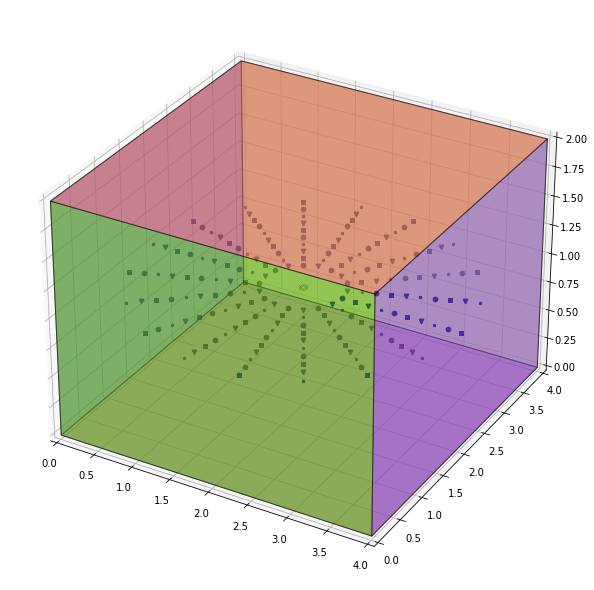

In [137]:
room = create_simulation_room()
sources = create_sound_sources(resolution=20)
fs, audio = wavfile.read("../sounds/CantinaBand3.wav")

# Add every single source to the room
for angle, sources in sources.items():
    for _, source in sources:
        room.add_source(source, signal=audio, delay=0.5)

# Plot the room
fig, ax = room.plot()
fig.set_size_inches(8, 8)
ax.set_xlim([0, 4])
ax.set_ylim([0, 4])
ax.set_zlim([0, 2]);

### Creating training and testing datasets

In [107]:
def gcc_phat(x_1, x_2, FS=16000):
    """
    Function that will compute the GCC-PHAT
    cross-correlation of two separate audio channels
    
    Returns:
        A 1-D GCC vector
    """
    
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.09 m is the mic array diameter and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.09 / 340 * FS)
    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See http://www.xavieranguera.com/phdthesis/node92.html for reference
    CC = X_1 * np.conj(X_2)
    
    cc = np.fft.irfft(CC, n=n)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc


def create_observations(dataframe, samples=1, step=1, resolution=20):
    """
    Create list of observations from the pandas dataframe.
    Each observation will be a GCC matrix, where each row is a vector
    of GCC between a given pair of microphones.
    
    Returns: 
        a tuple of observations and their corresponding labels
    """
    
    # Lists of observations and labels that will be populated
    X = []
    y = []
    
    # Loop through the dataframe and take subframes
    for i in range(0, len(dataframe) - samples + 1, step):
        sub_df = dataframe.iloc[i : i + samples]
        
        # Extract the label as the most common label
        # from the subframe
        label = mode(sub_df['angle'])
        rounded_label = math.floor(label / resolution) * resolution
        y.append(rounded_label)
        
        # Extract the observation from subframe by discarding the label column
        observation = np.array(sub_df.iloc[:, :-1])
        
        mic_pairs = combinations(dataframe.columns[:-1], r=2)
        
        # Initialize a transformed observation, that will be populated with GCC vectors
        # of the observation
        transformed_observation = []
        
        # Compute GCC for every pair of microphones
        for mic_1, mic_2 in mic_pairs:
            x_1 = observation[:, int(mic_1[-1]) - 1]
            x_2 = observation[:, int(mic_2[-1]) - 1]
            
            gcc = gcc_phat(x_1, x_2, FS=22050)
            
            # Add the GCC vector to the GCC matrix
            transformed_observation.append(gcc)
            
        # Add the GCC matrix to the list of observations
        X.append(transformed_observation)
        
    return X, y


def create_whole_dataset(encoder, samples=20, step=5, resolution=20):
    """
    Creates a whole dataset with a train/test split. 
    It is achieved by looping through all CSV files in the directory
    and creating observations from each of them. 
    
    These observations are then all concatenated together 
    into one large numpy array. The y labels are one-hot encoded.
    
    Returns:
        a tuple of size 4 in the format X_train, y_train, X_test, y_test
    """
    
    X, y = [], []
    
    files = os.listdir('../training_data')

    # Loop through all CSVs
    for i, file in enumerate(files):
        if file[-3:] != 'csv': 
            continue

        path = os.path.join('..', 'training_data', file)
        df = pd.read_csv(path, dtype=np.int16)
        
        # Create observations from a given CSV file
        X_temp, y_temp = create_observations(df, samples, step, resolution)
        
        # Accumulate observations
        X += X_temp
        y += y_temp
        
        print(f'File {i+1}/{len(files)}', end='\r')
        
    # Split data into training and testing
    y = np.array(y).reshape(-1, 1)  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)
    
    return X_train, y_train, X_test, y_test 


encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train, y_train, X_test, y_test = create_whole_dataset(encoder, samples=2205, step=1500, resolution=20)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((143532, 15, 13), (15948, 15, 13), (143532, 18), (15948, 18))

### Plot example GCC matrices for a few different angle labels

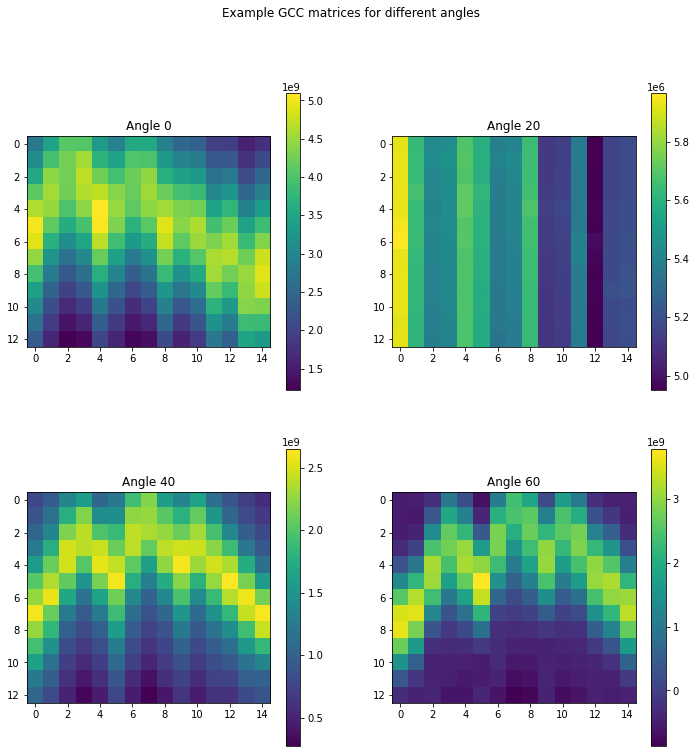

In [153]:
# Get training labels
angle_labels = encoder.inverse_transform(y_train)

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(9,9))
fig.suptitle('Example GCC matrices for different angles')
fig.set_size_inches(12, 12)

for i, label in enumerate(np.unique(angle_labels)[:4]):
    ax = axs[i//2][i%2]
    indices = np.where(angle_labels == label)[0]
    obs_idx = indices[np.random.randint(len(indices))]
    observation = X_train[obs_idx]
    
    ax.set_title(f'Angle {label}')
    im = ax.imshow(np.transpose(observation))
    fig.colorbar(im, ax=ax)